In [26]:
import os
import re
import json
import matplotlib.pyplot as plt
import numpy as np
import string
import pandas as pd
import pyspark.sql.functions as F
import nltk
import cPickle as pickle


from pyspark.ml.clustering import LDA
from pyspark.ml.linalg import Vectors, SparseVector
#from pyspark.mllib.clustering import LDA, LDAModel
#from pyspark.mllib.linalg import Vectors, SparseVector
from os import listdir
from os.path import isfile, join
from scipy.sparse import csr_matrix
from sklearn.metrics import mean_squared_error
from sklearn.manifold import TSNE
from itertools import chain
from scipy.sparse import coo_matrix
from pyspark.mllib.linalg.distributed import CoordinateMatrix, MatrixEntry, IndexedRow, IndexedRowMatrix
from pyspark.sql import Row
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import SGDClassifier, RidgeClassifierCV
from operator import add
from pyspark.sql.functions import udf
from pyspark.sql import SparkSession
from pyspark.sql.types import IntegerType, FloatType
from __future__ import print_function, unicode_literals, with_statement, absolute_import, generators, nested_scopes, division
from pyspark.sql.functions import mean, stddev
%matplotlib inline

In [2]:
# Local Spark
# spark session is now the entry point of spark program
# for line 8, can use local[n] for run spark locally with n cores

runLocal = True
if runLocal == True:
    spark = SparkSession.builder \
        .master('local[50]') \
        .appName("Word Count") \
        .config("spark.driver.maxResultSize", "15g")\
        .getOrCreate()
else:
    #p = subprocess.Popen(['sinteractive', '--partition=broadwl', '--cpus-per-task=10', '--time=00:30:00'], stdout=subprocess.PIPE, shell = True)
    #print(p.stdout.read())
    # start spark master program on this machine and register worker nodes
    os.system('start-spark-slurm.sh&') # use & to put it into background
    # get ip address of this machine
    ip = os.popen('hostname -i').read().strip('\n')
    # change 'local' to be ip of master node
    spark = SparkSession.builder \
        .master('spark://' + ip + ':7077') \
        .appName('Word Count') \
        .config("spark.driver.maxResultSize", "15g")\
        .getOrCreate()
    print('Spark Session web UI: http://{}:4040'.format(ip))

In [3]:
data = spark.read.option('header', 'true').csv('/project/cmsc25025/stackexchange/20161215StatsPostsMerged.csv').dropna()
data.show(5)

+---+--------------------+
| Id|           CleanBody|
+---+--------------------+
|  1|Eliciting priors ...|
|  2|"What is normalit...|
|  3|"What are some va...|
|  4|"Assessing the si...|
|  6|"The Two Cultures...|
+---+--------------------+
only showing top 5 rows



# (a)
Process the data to determine a word vocabulary. You should get a vocabulary of size around 10,000 words or so—it’s up to you to decide. Describe the steps you take to process the data and the criteria you use to select the vocabulary.

In [4]:
#initialize stop words
stop_words_nltk = nltk.corpus.stopwords.words('english')

def trans(t):
    return t.lower().encode('utf-8').translate(string.maketrans("",""), string.punctuation).strip().split()

In [5]:
# header = data.rdd.first()
# dataRDD = data.rdd.filter(lambda line: line != header)

In [6]:
words = data.rdd.flatMap(lambda x: trans(x[1])).collect()

word_dict = nltk.FreqDist(words)
for key in word_dict.keys():
    if key in stop_words_nltk:
        word_dict.pop(key, None)
    if word_dict[key] <= 50:
        word_dict.pop(key, None)
#len(word_dict): 10548
vocab = sorted(word_dict.keys())

/software/python-2.7.12-el7-x86_64/lib/python2.7/site-packages/ipykernel/__main__.py:5: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal


In [7]:
n_vocab = len(vocab)

In [8]:
n_vocab

8484

Steps of obtaining the vocabulary is described below:
- lowercase all words
- remove puntuation
- split on space
- remove stopwords
- remove words that have appeared more than 50 times

# (b) 
Now fit topic models on the collection. Divide the corpus into training and validation documents–use a 90%/10% split, holding out about 9,000 documents. You will need to write a parser that maps each entry to a sequence of word-id/count pairs.
You may use the LDA implementation from either spark.mllib or spark.ml. The fol- lowing resources may be helpful:
- http://goo.gl/Y308G4 (Topic modeling with LDA: MLlib meets GraphX) 
- http://goo.gl/lIacvm (spark.mllib.clustering.LDA) 
- http://goo.gl/Ro2Fnt (spark.ml.clustering.LDA)

Train topic models using different numbers of topics; a good starting point would be around 30 topics. Display the top 10 or so words (in decreasing order of probability βkw) in each topic. Comment on the “meaning” or interpretation of several of the topics. Select several documents, and display the most probable topics for each of them (ac- cording to the posterior distribution over θ). Do the assigned topics make sense? Com- ment on your findings.
You will need to read the documentation for the implementation that you choose (mllib or ml), to learn how to carry out these steps.

In [9]:
from collections import defaultdict

def parse(r):
    body = r[1]
    words = trans(body)
    w_vect = defaultdict(int)
    for w in words:
        if w in vocab:
            w_vect[vocab.index(w)] += 1
    w_vect = sorted(w_vect.items())
    try:
        keys, values = map(list, zip(*w_vect))
    except:
        keys, values = [], []
    return Vectors.sparse(n_vocab, keys, values)

def und_topics(r):
    words = [vocab[i] for i in r[1]]
    return (pd.DataFrame({'wd': words, 'wt': r[2]}).sort_values(by = 'wt', ascending = False))

In [10]:
train_data, vali_data = data.rdd.randomSplit([0.9, 0.1], 1234)
trainRDD = train_data.map(lambda x: (x[0], parse(x)))
valiRDD = vali_data.map(lambda x: (x[0], parse(x)))

trainDF = spark.createDataFrame(trainRDD,["id", "features"]).cache()
valiDF = spark.createDataFrame(valiRDD,["id", "features"]).cache()

In [84]:
d_l = data.collect()

In [12]:
lda = LDA(k=30, maxIter=50, optimizer="online")
model = lda.fit(trainDF)
dtDF = model.describeTopics().toPandas()

transformed = model.transform(trainDF)
tDF = transformed.toPandas()

In [88]:
topic_labels = []
for i in range(30):
    t_l = und_topics(list(dtDF.iloc[i,:]))
    print("Topic", i)
    print(t_l , '\n')
    topic_labels.append(list(t_l['wd']) )

Topic 0
             wd        wt
0  multivariate  0.054830
1   mahalanobis  0.036536
2      spectral  0.033550
3    univariate  0.020249
4      spectrum  0.018913
5      distance  0.011340
6     whitening  0.008485
7           iv1  0.007533
8       spectra  0.007335
9           iv2  0.006695 

Topic 1
         wd        wt
0  kurtosis  0.062246
1  skewness  0.061426
2   profile  0.026934
3    skewed  0.019503
4      skew  0.019000
5    pseudo  0.012359
6    excess  0.009988
7   moments  0.009914
8     floor  0.009808
9    intake  0.009335 

Topic 2
           wd        wt
0       model  0.026046
1        data  0.021892
2  regression  0.011767
3       would  0.009876
4       using  0.009009
5   variables  0.008520
6         use  0.008350
7         one  0.007645
8           r  0.007576
9    variable  0.007389 

Topic 3
          wd        wt
0      group  0.041554
1     groups  0.032972
2      anova  0.028714
3  treatment  0.015937
4    control  0.014456
5   repeated  0.014340
6   measu

By looking at the top words of each topic, it's easy to interpret the topics:
   - Topic 0: measuring distance
   - Topic 1: skewness
   - Topic 2: modeling data/ regression
   - Topic 3: grouping variables
   - Topic 4: statistical data analysis
   - Topic 5: matrix..?
   - Topic 6: clustering
   - Topic 7: dealing missing data with imputation
   
   ...

In [96]:
def doc_topics(i):
    print("Document:", d_l[i], '\n')
    
    td = tDF['topicDistribution'][i]
    topic_n = np.arange(30)
    d_topic = pd.DataFrame({'Topic': topic_n, 'topicDistribution': td, 'label': topic_labels}).\
                sort_values(by = 'topicDistribution', ascending = False)[:5]
    print('Top 5 topics in this document:')
    print(d_topic)

In [101]:
for i in [0, 10000, 833]:
    doc_topics(i)
    print('\n')

Document: Row(Id=u'1', CleanBody=u"Eliciting priors from experts How should I elicit prior distributions from experts when fitting a Bayesian model? John Cook gives some interesting recommendations. Basically, get percentiles/quantiles (not means or obscure scale parameters!) from the experts, and fit them with the appropriate distribution.    Eliciting priors is a tricky business.   Statistical Methods for Eliciting Probability Distributions and Eliciting Probability Distributions are quite good practical guides for prior elicitation.  The process in both papers is outlined as follows:  background and preparation; identifying and recruiting the expert(s); motivation and training the expert(s); structuring and decomposition (typically deciding precisely what variables should be elicited, and how to elicit joint distributions in the multivariate case); the elicitation itself. Of course, they also review how the elicitation results in information that may be fit to or otherwise define di

By comparing the document text and topics infered by our model, we could realize that the model is indeed doing a pretty good job.

The first document talks about eliciting priors and the most probable topic is about "data, distribution, would, mean, sample, number", and the second topic is about data analysis and statistics, which are exactly what it is.

The second ask about properties of a good a classifier, while the most probable topics seem to be about time series and distribution, which are not very close. This might be due to the fact that this document is very short compared to the others.

The last one is about cox regression and time scale, and the inferred topics are indeed about modeling, data analysis and regression. So, it's pretty accurate.

# (c)
Now you will investigate how to evaluate the model more quantitatively2. 

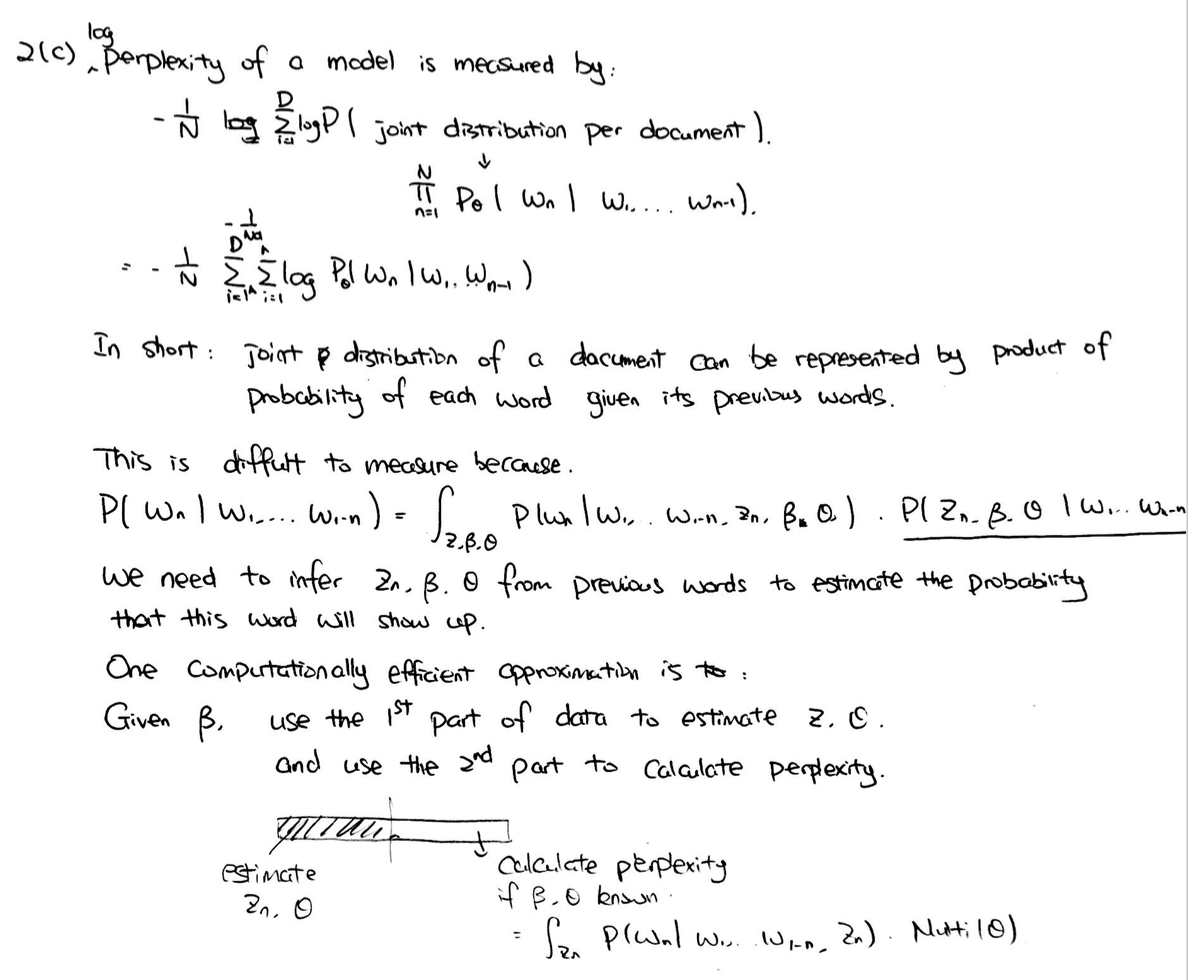

In [105]:
from IPython.display import Image
Image(filename='2c.png') 

# (d)
Now evaluate the test set perplexity for a range of models, fit with K = 10, 20, . . . , 200 topics (or an appropriate range of your own choice). Plot the test set perplexity as a function of number of topics. Which is the best model? Do you notice any qualitative difference in the topics as K increases? Comment on your overall findings.

In [77]:
K = np.arange(10,201,20)

In [78]:
lps = []
for k in K:
    print('k =', k)
    lda = LDA(k=k, seed=1, optimizer="online")
    model = lda.fit(trainDF)
    lps.append(model.logPerplexity(valiDF))  

k = 10
k = 30
k = 50
k = 70
k = 90
k = 110
k = 130
k = 150
k = 170
k = 190


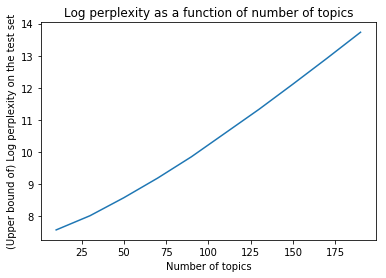

In [80]:
plt.plot(K,lps)
plt.title('Log perplexity as a function of number of topics')
plt.xlabel('Number of topics')
plt.ylabel('(Upper bound of) Log perplexity on the test set')
plt.show()

In [103]:
for k in [60, 200]:
    print('k =', k)
    lda = LDA(k=k, seed=1, optimizer="online")
    model = lda.fit(trainDF)
    dtDF = model.describeTopics().toPandas()

    for i in range(k):
        t_l = und_topics(list(dtDF.iloc[i,:]))
        print("Topic", i)
        print(t_l , '\n')

k = 60
Topic 0
          wd        wt
0  causality  0.016993
1    granger  0.012929
2    speaker  0.005587
3       test  0.004840
4    marbles  0.004593
5       data  0.004035
6      audio  0.003796
7         p1  0.003788
8     marble  0.003443
9         p2  0.003249 

Topic 1
           wd        wt
0       sales  0.022907
1     disease  0.020970
2        data  0.014015
3  prevalence  0.010457
4       month  0.010348
5      sample  0.006258
6      months  0.006159
7   incidence  0.006029
8        size  0.005938
9       study  0.005338 

Topic 2
                wd        wt
0             time  0.041508
1           series  0.041014
2            model  0.022367
3             data  0.010611
4         forecast  0.008335
5            arima  0.008331
6          process  0.007629
7  autocorrelation  0.007407
8            using  0.006030
9       stationary  0.005997 

Topic 3
            wd        wt
0       funnel  0.011998
1        churn  0.006004
2      control  0.004479
3  publication  0.0

By looking at these topics, it seems that as the number of topics increases, the topics become more precise. So, as far as I can tell, the quality the topics are increasing as the number of topics increases.